### Criando um dataset para benchmark do OCR

Esse jupyter tem como objetivo percorrer as imagens presentes no diretório 'imgs", dividir separar as placas de carros, as quais terão seus textos extraídos.
Em seguida, será possível comparar os resultados obtidos com o OCR escolhido

In [30]:
import os
from ultralytics import YOLO
from paddleocr import PaddleOCR
import cv2
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

---

### Funções auxiliares:

Função para separar a placa das imagens

In [ ]:
def calculate_next_id():
    # Load the existing IDs from the text file
    plates = os.listdir('plate_imgs')
    max_id = 0
    for plate in plates:
        # Extract the numeric part of the filename
        try:
            plate_id = int(plate.split('_')[1].split('.')[0])
            if plate_id > max_id:
                max_id = plate_id
        except ValueError:
            continue
    
    return max_id + 1 if max_id > 0 else 0

def classify_and_crop(image_path):
    # Load model
    model = YOLO('../last.pt')
    
    # Run inference
    results = model(image_path)
    
    # Read the original image
    original_image = cv2.imread(image_path)
    imgnames = []


    # Iterate over results
    for i, result in enumerate(results):
        boxes = result.boxes.xyxy.cpu().numpy()  # Get bounding boxes in (x1, y1, x2, y2) format

        for j, (x1, y1, x2, y2) in enumerate(boxes):
            # Convert coordinates to integers
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

            # Crop the image
            cropped = original_image[y1:y2, x1:x2]

            # Save the cropped image
            id = calculate_next_id()
            output_filename = f'plate_imgs/plate_{id}.jpg'
            imgnames.append(output_filename)
            cv2.imwrite(output_filename, cropped)
    return imgnames            

Função para extrair o texto das placas

In [ ]:
def change_char_in_position(word, position):
    if position < len(word):
        if word[position].isdigit():
            digit = word[position]
            if digit == '8':
                word = word[:position] + 'B' + word[position+1:]
            elif digit == '1':
                word = word[:position] + 'I' + word[position+1:]
    return word

def detect_blue_strip(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return False

    height, width = image.shape[:2]
    top_strip = image[0:int(height * 0.15), 0:width]  # faixa de cima

    hsv = cv2.cvtColor(top_strip, cv2.COLOR_BGR2HSV)

    # Faixa de azul (com tolerância maior para placas borradas)
    lower_blue = np.array([90, 40, 40])
    upper_blue = np.array([140, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    blue_ratio = cv2.countNonZero(mask) / (top_strip.shape[0] * top_strip.shape[1])
    return blue_ratio > 0.03


def correct_plate(word, is_new_plate):
    word = word.replace("-", "")
    if len(word) < 7:
        return None

    for pos in [0, 1, 2]:
        if word[pos].isdigit():
            word = change_char_in_position(word, pos)
    
    if is_new_plate and len(word) > 4 and word[4].isdigit():
        word = change_char_in_position(word, 4)

    # Verifica os dois formatos válidos
    if re.match(r'^[A-Z]{3}\d{4}$', word) or re.match(r'^[A-Z]{3}\d[A-Z]\d{2}$', word):
        return word
    return None

ocr = PaddleOCR(use_angle_cls=True, lang='en', show_log=False)

def extract_plate_from_image(image_path):
    is_new_plate = detect_blue_strip(image_path)
    result = ocr.ocr(image_path, cls=True)
    
    if not result or result[0] is None:
        print("No text detected.")
        return None    
    
    detected_words = []
    for line in result:
        for word_info in line:
            text = word_info[1][0].replace(" ", "")
            if text.lower() == "brasil":
                is_new_plate = True
            else:
                detected_words.append((text, word_info[1][1]))  # (text, confidence)
    
    print(f"Palavras detectadas: {detected_words}")
    print(f"É nova placa? {is_new_plate}")    
    
    # Tenta cada palavra isolada
    for word_tuple in detected_words:
        corrected = correct_plate(word_tuple[0], is_new_plate)
        if corrected:
            return corrected

    # Tenta pares de palavras combinadas
    for i in range(len(detected_words)):
        for j in range(i+1, len(detected_words)):
            combined = detected_words[i][0] + detected_words[j][0]
            corrected = correct_plate(combined, is_new_plate)
            if corrected:
                return corrected

    return None


----

### Inicio:

Percorrendo as imagens:

In [ ]:
# Cria o diretorio plate_imgs
if not os.path.exists('plate_imgs'):
    os.makedirs('plate_imgs')

In [ ]:
# Carrega as imagens
imgs = os.listdir('../new_imgs')
imgs.sort(key=lambda x: int(re.search(r'(\d+)', x).group(0)) if re.search(r'(\d+)', x) else 0)
print(f"Imagens encontradas: {imgs}")
print(len(imgs))

for img in imgs:
    # Classifica e recorta a imagem
    image_path = os.path.join('../new_imgs', img)
    imgnames = classify_and_crop(image_path)

In [205]:
# Percorre plates/plates_imgs, caso tenha uma placa fora de ordem, renomeia
id = 0
for plate in os.listdir('plate_imgs'):
    # Renomeia a imagem
    new_name = f'plate_imgs/plate_{id}.jpg'
    os.rename(f'plate_imgs/{plate}', new_name)
    id += 1

In [208]:
placas_text = [
    'PYP5727',
    'QUP8066',
    'ELS7575',
    'EJA9040',
    'ELS7575',
    'EHJ9C82',
    'LUO1J10',
    'KWE8269',
    'KRF8219',
    'KWE8269',
    'QQF5108',
    'LMT6I14',
    'PWY3G12',
    'QQA5348',
    'LTF6B00',
    'LMI7G15',
    'GIU0480',
    'EZE8592',
    'RNC4H56',
    'STT1A06',
    'SIB2A26',
    'CON1454',
    'ELP1978',
    'GGW4I41',
    'EHI0H58',
    'GCZ7D94',
    'GDY4G44',
    'SWI3B77',
    'GCZ7D94',
    'FHP9G04',
    'CGN9J94',
    'GCZ7D94',
    'FHP9G04',
    'SUW1C12',
    'FWR5B86',
    'FHP9G04',
    'EXX7619',
    'DSV7C13',
    'DSV7C13',
    'SSZ5I11',
    'FNC1F27',
    'CUH4G26',
    'FHP9G04',
    'FHP9G04',
    'FWR5B86',
    'SWI3B77',
    'CUY1B80',
    'DES5518',
    'GKC4H60',
    'GAR4G31',
    'GHV7564',
    'GKC4H60',
    'FMJ6399',
    'ALF8F22',
    'FRY2I96',
    'GKC4H60',
    'BSX6F35',
    'GKC4H60',
    'DES5518',
    'GKC4H60',
    'GDY4G44',
    'STK3G35',
    'GCI4125', #62
    'GCZ7D94',
    'GDY4G44',
    'FHP9G04',
    'CGN9J94',
    'GCZ7D94',
    'FHJ4I79',
    'GQD1C83',
    'ELC4D87',
    'FHJ4I79',
    'GQD1C83',
    'DLZ1811',
    'GBT3243',
    'GQD1C83',
    'AKD1918',
    'GAZ4E59',
    'OLY7905',
    'BSX4411',
    'BYQ8A11',
    'EYG1E36',
    'GDW0625',
    'CVI2D00',
    'FGB4606',
    'FSY8627',
    'SGL2D15',
    'FEV6689',
    'EEU1483',
    'TKX4F76',
    'FWS6777',
    'FEG0724',
    'FSB8789',
    'EYB6C13',
    'BBJ0B66',
    'TCD4H11',
    'FIL0G41',
    'FON1982',
    'ESZ5780',
    'TDA6C82',
    'FRQ0557',
    'BBJ0B66',
    'BBJ0B66',
    'FSD9I02',
    'SCH6B17',
    'SUU4H54',
    'BXZ6873', # Alertou ser placa nova mas era antiga....
    'GBD5467',
    'FFM4474',
    'FPV5013',
    'SYU6B72',
    'FJT5J15',
    'FAM1765',
    'ESU2J46',
    'EQA9A33',
    'RT09J51',
    'SFB1B33',
    'FVM6258',
    'GCM2176',
    'GCF2J95',
    'RTK7B29',
    'GBM3926',
    'GHM6J62', # Reconheceu que era placa nova mas nao trocou j por 3
    'FVCOE27',
    'EOD4930',
    'TDD9H19',
    'EOD4930',
    'DZU0674',
    'STM8I03',
    'DMW1E38',
    'GDI0123', # 130 Detectou incorretamente placa nova
    'GGA8897', # Detectou incorretamente placa nova
    'GFJ8A12',
    'FZB3B41',
    'OLY7905',
    'SVV8G37'
]
placas_text[133]

'FZB3B41'

plate_imgs/plate_135.jpg


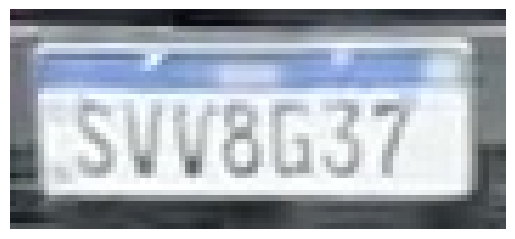

Palavras detectadas: [('SVV8G37', 0.987362802028656)]
É nova placa? True
SVV8G37


In [209]:
# exibe a imgem: ./plate_imgs/plate_{id}.jpg
id_analisado =135
img_path = f'plate_imgs/plate_{id_analisado}.jpg'
print(img_path)
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()
print(extract_plate_from_image(img_path))

In [210]:
df = pd.DataFrame(columns=['filename', 'plate'])

id = 0
for placa_text in placas_text:
    df.loc[id] = [f'plate_imgs/plate_{id}.jpg', placa_text]
    id += 1

df.to_csv('./plates.csv', index=False)